# IIT 4.0 demonstration

PyPhi is a software toolbox that provides the reference implementation of Integrated Information Theory (IIT).

This notebook is to be used with the [`feature/iit-4.0` branch of PyPhi](https://github.com/wmayner/pyphi/tree/feature/iit-4.0). It is meant to accompany the IIT 4.0 paper, [available here](https://doi.org/10.48550/arXiv.2212.14787).

## Installing PyPhi

First, we install use `pip` to install PyPhi and its dependencies:

In [ ]:
!python -m pip install -U git+https://github.com/wmayner/pyphi.git@feature/iit-4.0

In [ ]:
import pyphi
import math
import numpy as np

pyphi.config.PROGRESS_BARS = False
pyphi.config.PARALLEL = False

## Loading system data

This tutorial will be based on the second system from Figure 8C of the IIT 4.0 paper:
_"Functionally equivalent networks with different Φ-structures"_.

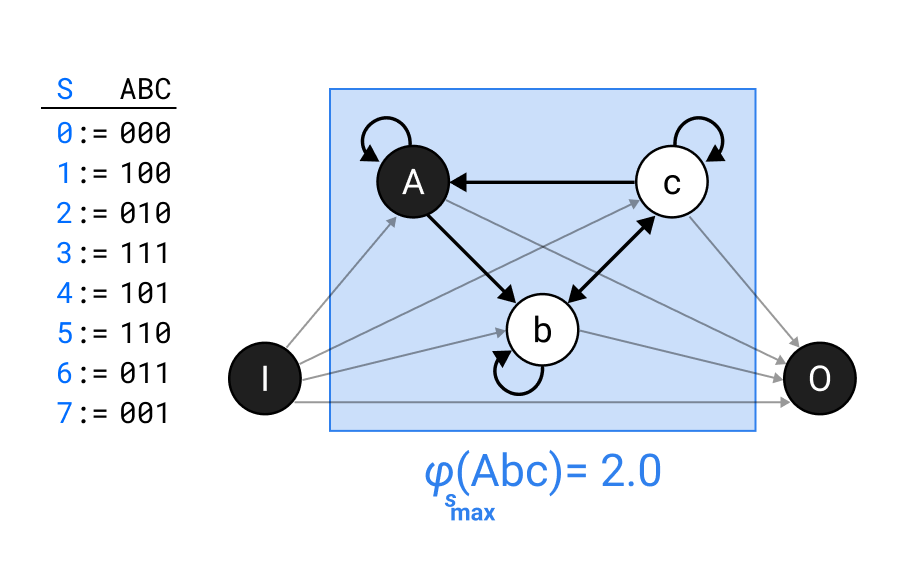

Background conditions (nodes "I" and "O") have already been fixed to
"I"=ON, "O"=ON in the hypothetical 5-node Transition Probability Matrix (TPM).
Therefore, we will start from a TPM which only contains nodes "A", "B", "C".

In [ ]:
import pyphi
import numpy as np

node_labels = ("A", "B", "C")

# TPM in state-by-node format (see `help(pyphi.Network)` for information on TPM
# representations).
tpm = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 1],
    [0, 0, 0],
    [1, 1, 0],
    [0, 0, 1],
    [1, 0, 1],
])

# The network's adjacency matrix. In its absence, PyPhi will assume all-to-all
# connectivity.
connectivity_matrix = np.array([
    [1, 1, 0,],  # A->A, A->B
    [0, 1, 1,],  # B->B, B->C
    [1, 1, 1,],  # C->A, C->B, C->C
])

We begin by instantiating a `Network` object. This holds the physical
substrate, which serves as the operational starting point to assess the causal
powers and intrinsic properties of a system.

In [ ]:
network = pyphi.Network(tpm, cm=connectivity_matrix, node_labels=node_labels)
network

Network(ExplicitTPM([[[[1. 0. 0.]
   [0. 0. 0.]]

  [[1. 1. 1.]
   [0. 0. 1.]]]


 [[[0. 1. 0.]
   [1. 1. 0.]]

  [[0. 1. 1.]
   [1. 0. 1.]]]]), cm=[[1 1 0]
 [0 1 1]
 [1 1 1]])

Then we instantiate a `Subsystem` object. All further analysis of the resulting
`candidate_system` will be performed for a `state` of interest.
Here we use the full network ("A", "B", "C").
In general, system nodes that are excluded from the keyword argument `nodes` act
as fixed background units to the analysis, which means that the TPM is
conditioned on their respective state as specified by `state`.

In [ ]:
# A=ON, B=OFF, C=OFF (Abc in Figure 7).
state = (1, 0, 0)

candidate_system = pyphi.Subsystem(network, state, nodes=node_labels)
candidate_system

Subsystem(A, B, C)

# System Irreducibility Analysis: identifying complexes

From the System Irreducibility Analysis (SIA), we can see that the
`candidate_system` in state `(1, 0, 0)` exists (it has both cause and effect power, since II_c > 0 and II_e > 0) in a way that is intrinsic (within the system
ABC), informative (it picks out specific previous and next states), and
integrated ($φ_s$ > 0 for the minimum partition).

In [ ]:
sia = pyphi.new_big_phi.sia(candidate_system)
sia

┌──────────────────────────────────┐
│ SystemIrreducibilityAnalysis     │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━      │
│      Subsystem:  A,B,C           │
│  Current state:  1,0,0           │
│            φ_s: 2.0              │
│ Normalized φ_s: 0.4              │
│          CAUSE:  (0, 0, 0)       │
│           II_c: 3.0              │
│         EFFECT:  (0, 1, 0)       │
│           II_e: 3.0              │
│   #(tied MIPs): 2                │
│      Partition:                  │
│                 3 parts: {A,B,C} │
│                 [[0 0 1]         │
│                  [1 0 1]         │
│                  [1 1 0]]        │
└──────────────────────────────────┘

Two tied minimum partitions (MIPs) were found, one of which cuts the
`candidate_system` into three parts. The 1's in the partition matrix
indicate connections that are severed. Note that system partitions are directed,
so the matrix may be asymmetric.

In [ ]:
sia.partition

3 parts: {A,B,C}
[[0 0 1]
 [1 0 1]
 [1 1 0]]

We can access properties which hold the corresponding system integrated
information ($φ_s$, its minimal irreducibility), and a normalized
system integrated information ($φ_s$ divided by the maximum $φ_s$ that
could be obtained for a system of three nodes).

In [ ]:
print(f"φ_s = {sia.phi}")
print(f"φ_s_norm = {sia.normalized_phi}")

φ_s = 2.0
φ_s_norm = 0.4


By the principle of minimal existence, $φ_s$ must be the minimum between the $φ$
of the maximally irreducible cause and the maximally irreducible effect within
the `candidate_system` itself. For this particular `candidate_system` at the
current particular `state`, it turns out cause and effect are equally
irreducible.

In [ ]:
print(sia.cause.phi)
print(sia.effect.phi)

2.0
2.0


## Maximal cause-effect state

Let's look more closely at one of them:

In [ ]:
sia.effect

Repertoire irreducibility analysis
  φ = 2
  Normalized φ = None
  Mechanism: [A,B,C]
  Purview: [A,B,C]
  Specified state:
  ┌─────────────────────┐
  │   Specified EFFECT  │
  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
  │ EFFECT:  (0, 1, 0)  │
  │   II_e: 3.0         │
  └─────────────────────┘
  Direction: EFFECT
  Partition:
    3 parts: {A,B,C}
    [[0 0 1]
     [1 0 1]
     [1 1 0]]
  Forward probability: 
      1.0
  Partitioned forward probability:
      0.25
  #(state ties): 0
  #(partition ties): 0

Recall that $φ_s$ is evaluated for a specific cause or effect state, which is
defined as the state that maximizes intrinsic information ($ii$). We can
inspect this state:

In [ ]:
sia.effect.specified_state

┌─────────────────────┐
│   Specified EFFECT  │
│ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
│ EFFECT:  (0, 1, 0)  │
│   II_e: 3.0         │
└─────────────────────┘

Let's go deeper into PyPhi's API to recompute the specified effect state:

In [ ]:
maximal_effect_state = candidate_system.intrinsic_information(
    direction=pyphi.Direction.EFFECT,
    mechanism=candidate_system.node_indices,
    purview=candidate_system.node_indices,
)

# Note: You can use also
# `pyphi.new_big_phi.system_intrinsic_information(candidate_system)`
# to obtain both cause and effect states at once.

maximal_effect_state

┌─────────────────────┐
│   Specified EFFECT  │
│ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
│ EFFECT:  (0, 1, 0)  │
│   II_e: 3.0         │
└─────────────────────┘

## System integrated information

Let's use PyPhi to recompute `sia.effect` and $φ_s$. We will use the fact
that we already know the MIP to avoid going through all partitions.

In [ ]:
# Note: the full set of system partitions may be manually computed by invoking:
system_partitions = pyphi.partition.system_partitions(
    candidate_system.node_indices, node_labels=candidate_system.node_labels
)

cut_candidate_system = candidate_system.apply_cut(sia.partition)

maximal_effect_state = pyphi.new_big_phi.system_intrinsic_information(candidate_system)

We can now compute the integration value with respect to a direction,
`candidate_system`, `cut_candidate_system` and the `maximal_effect_state` we
had already obtained.

In [ ]:
pyphi.new_big_phi.integration_value(
    pyphi.Direction.EFFECT, candidate_system, cut_candidate_system, maximal_effect_state
)

Repertoire irreducibility analysis
  φ = 2
  Normalized φ = None
  Mechanism: [A,B,C]
  Purview: [A,B,C]
  Specified state:
  ┌─────────────────────┐
  │   Specified EFFECT  │
  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
  │ EFFECT:  (0, 1, 0)  │
  │   II_e: 3.0         │
  └─────────────────────┘
  Direction: EFFECT
  Partition:
    3 parts: {A,B,C}
    [[0 0 1]
     [1 0 1]
     [1 1 0]]
  Forward probability: 
      1.0
  Partitioned forward probability:
      0.25
  #(state ties): 0
  #(partition ties): 0

## Exclusion: identifying the first complex

We know the `candidate_system` is irreducible. But is it maximally
irreducible? We will go through all its subsets, computing system
irreducibility analyses for all of them.

Indeed, in this case the full `candidate_subsystem` composed of nodes "A", "b", "c"
wins over all its subsets (note that in general, the largest subset is not necessarily the maximally irreducible one).

In [ ]:
for sia in pyphi.new_big_phi.all_complexes(network, state):
    node_labels = candidate_system.node_labels.coerce_to_labels(sia.node_indices)
    print(f"φ_s = {sia.phi} {node_labels}")

# Note that PyPhi's API includes a function for finding the maximal complex:
pyphi.new_big_phi.maximal_complex(network, candidate_system.state)

φ_s = 2.0 ('A', 'B', 'C')
φ_s = 0.0 ('A', 'C')
φ_s = 0.0 ('A', 'B')
φ_s = 0.0 ('C',)
φ_s = 1.0 ('A',)


┌──────────────────────────────────┐
│ SystemIrreducibilityAnalysis     │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━      │
│      Subsystem:  A,B,C           │
│  Current state:  1,0,0           │
│            φ_s: 2.0              │
│ Normalized φ_s: 0.4              │
│          CAUSE:  (0, 0, 0)       │
│           II_c: 3.0              │
│         EFFECT:  (0, 1, 0)       │
│           II_e: 3.0              │
│   #(tied MIPs): 2                │
│      Partition:                  │
│                 3 parts: {A,B,C} │
│                 [[0 0 1]         │
│                  [1 0 1]         │
│                  [1 1 0]]        │
└──────────────────────────────────┘

# Distinctions

Now that the maximal complex or physical substrate of consciousness has been
identified, we can "unfold" the substrate to examine the compositional structure of the distinctions it specifies and the relations among them.

Note: We will keep referring to the `candidate_subsystem`.

For example, does mechanism "A" specify an irreducible distinction? Yes, it is:

In [ ]:
mechanism = (0,)

# Note: Mechanism partitions are represented as fractions, with
# mechanism parts in the numerator and purview parts in the denominator.

candidate_system.concept(mechanism)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Distinction: mechanism = [A], state = [1]
           φ = 0.4387218755409           
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
┌─────────────────────────────────────┐┌─────────────────────────────────────┐
│  Maximally-irreducible cause        ││  Maximally-irreducible effect       │
│    φ = 1/2                          ││    φ = 0.4387218755409              │
│    Normalized φ = 1/4               ││    Normalized φ = 0.4387218755409   │
│    Mechanism: [A]                   ││    Mechanism: [A]                   │
│    Purview: [A,C]                   ││    Purview: [B]                     │
│    Specified state:                 ││    Specified state:                 │
│    ┌─────────────────┐              ││    ┌─────────────────────────────┐  │
│    │ Specified CAUSE │              ││    │       Specified EFFECT      │  │
│    │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │              ││    │ ╍

Does the higher-order mechanism "Ab" specify an irreducible distinction? It does:

In [ ]:
mechanism = (0, 1)
candidate_system.concept(mechanism)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Distinction: mechanism = [A,B], state = [1, 0]
             φ = 0.4150374992788              
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
┌─────────────────────────────────────┐┌─────────────────────────────────────┐
│  Maximally-irreducible cause        ││  Maximally-irreducible effect       │
│    φ = 1/2                          ││    φ = 0.4150374992788              │
│    Normalized φ = 1/8               ││    Normalized φ = 0.4150374992788   │
│    Mechanism: [A,B]                 ││    Mechanism: [A,B]                 │
│    Purview: [A,B,C]                 ││    Purview: [B]                     │
│    Specified state:                 ││    Specified state:                 │
│    ┌────────────────────┐           ││    ┌──────────────────┐             │
│    │  Specified CAUSE   │           ││    │ Specified EFFECT │             │
│    │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │          

What about mechanism "Ac"? This mechanism does not specify a
distinction, because it is
reducible on the cause side:

In [ ]:
mechanism = (0, 2)
candidate_system.concept(mechanism)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Distinction: mechanism = [A,C], state = [1, 0]
                    φ = 0                     
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
┌─────────────────────────────────────┐┌─────────────────────────────────────┐
│  Maximally-irreducible cause        ││  Maximally-irreducible effect       │
│    φ = 0                            ││    φ = 1.4150374992788              │
│    Normalized φ = 0                 ││    Normalized φ = 0.4716791664263   │
│    Mechanism: [A,C]                 ││    Mechanism: [A,C]                 │
│    Purview: [B,C]                   ││    Purview: [A,B]                   │
│    Specified state:                 ││    Specified state:                 │
│    ┌─────────────────┐              ││    ┌──────────────────┐             │
│    │ Specified CAUSE │              ││    │ Specified EFFECT │             │
│    │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │             

Notice that PyPhi picks a particular cause purview even though all purviews are reducible. You may restrict the search to a subset of purviews to convince
yourself that they are in fact reducible:

In [ ]:
mechanism = (0, 2)

cause_purviews = (
    c for c in pyphi.utils.powerset(candidate_system.node_indices)
    if c not in ((), (1,2))
)

candidate_system.concept(
    mechanism,
    cause_purviews=cause_purviews
)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Distinction: mechanism = [A,C], state = [1, 0]
                    φ = 0                     
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
┌─────────────────────────────────────┐┌─────────────────────────────────────┐
│  Maximally-irreducible cause        ││  Maximally-irreducible effect       │
│    φ = 0                            ││    φ = 1.4150374992788              │
│    Normalized φ = 0                 ││    Normalized φ = 0.4716791664263   │
│    Mechanism: [A,C]                 ││    Mechanism: [A,C]                 │
│    Purview: [A,B,C]                 ││    Purview: [A,B]                   │
│    Specified state:                 ││    Specified state:                 │
│    ┌────────────────────┐           ││    ┌──────────────────┐             │
│    │  Specified CAUSE   │           ││    │ Specified EFFECT │             │
│    │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │          

The `Subsystem` methods `candidate_system.mic()` and `candidate_system.mie()`
are useful if you are only interested in finding a maximally-irreducible cause
or effect. For example:

In [ ]:
mechanism = (0, 2)
candidate_system.mic(mechanism)

Maximally-irreducible cause
  φ = 0
  Normalized φ = 0
  Mechanism: [A,C]
  Purview: [B,C]
  Specified state:
  ┌─────────────────┐
  │ Specified CAUSE │
  │ ╍╍╍╍╍╍╍╍╍╍╍╍╍╍╍ │
  │ CAUSE:  (0, 0)  │
  │  II_c: 0.5      │
  └─────────────────┘
  Direction: CAUSE
  MIP:
     A     C     ∅ 
    ─── ✕ ─── ✕ ───
     ∅    B,C    ∅ 
  Forward probability: 
      0.5
  Partitioned forward probability:
      0.5
  #(state ties): 1
  #(partition ties): 0
  #(purview ties): 3

# Causal relations

Causal relations capture how the causes and/or effects of a set of distinctions overlap with each other.

We can obtain all 4 irreducible distinctions (mechanisms "A", "b", "c", "Ab"),
and then use them to find causal relations among them.

In [ ]:
distinctions = pyphi.compute.ces(candidate_system)

**NOTE:** Before computing relations, it is important to filter out distinctions that are incongruent with the state specified by the entire candidate system (this is done automatically by the `phi_structure()` function, discussed below).

In [ ]:
distinctions = distinctions.resolve_congruence(sia.system_state)

Now we can compute all relations among these distinctions:

In [ ]:
relations = pyphi.relations.relations(distinctions)
relations

═════════════════════════════════════
          ConcreteRelations          
═════════════════════════════════════
        Σφ_r: 1.8505010400440653
#(relations): 9                 
  ┌───────────────────────────────┐  
  │            Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.20751874963942188 │  
  │  Purview:  [a, c]             │  
  │ #(faces): 8                   │  
  └───────────────────────────────┘  
  ┌──────────────────────────────┐  
  │           Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.2924812503605781 │  
  │  Purview:  [a, c]            │  
  │ #(faces): 2                  │  
  └──────────────────────────────┘  
  ┌───────────────────────────────┐  
  │            Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.14624062518028905 │  
  │  Purview:  [B]                │  
  │ #(faces): 1                   │  
  └───────────────────────────────┘  
  ┌──────────────────────────

The output functions like a `set` object containing all the relations. Each relation in turn also functions like a `set` that contains the distinctions that are related. Additionally, relations have

 - A `relation.phi` value.
 - `relation.faces`: A set of relation faces, each corresponding to an overlap among the purviews of some causes and effefcts
 - `relation.purview`: The union of the face purviews (or, equivalently, the intersection of the distinction cause/effect purview unions).

Let's examine the relation between the first two distinctions.

In [ ]:
relation = pyphi.relations.relation(
    distinctions[:2]
)
relation

┌──────────────────────────────┐
│           Relation           │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│      φ_r: 0.2924812503605781 │
│  Purview:  [a, c]            │
│ #(faces): 2                  │
└──────────────────────────────┘

We can look at the relation's faces:

In [ ]:
relation.faces

frozenset({┌──────────────────────────┐
           │       RelationFace       │
           │ ━━━━━━━━━━━━━━━━━━━━━━━━ │
           │ Purview:  [a]            │
           │  Relata: 2               │
           │           Cause[0]/[0,2] │
           │           Cause[1]/[0,1] │
           └──────────────────────────┘,
           ┌───────────────────────────┐
           │        RelationFace       │
           │ ━━━━━━━━━━━━━━━━━━━━━━━━━ │
           │ Purview:  [c]             │
           │  Relata: 2                │
           │           Effect[1]/[2]   │
           │            Cause[0]/[0,2] │
           └───────────────────────────┘})

As with collections of relations and relations themselves, a relation face also functions like a `set`. It contains the causes/effects which have a nonempty congruent overlap among their purviews.

This congruent overlap is stored in the `purview` attribute:

In [ ]:
face = next(iter(relation.faces))
face.purview

{a}

# Cause-effect structure and big Φ

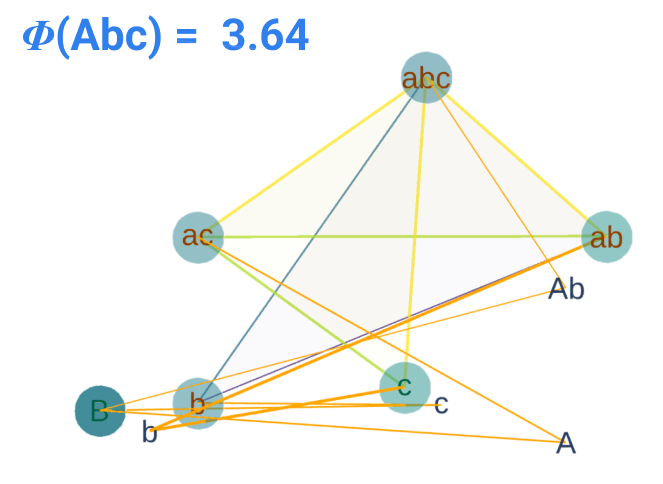


For convenience, PyPhi can be asked to fully unfold the cause-effect
structure of a `candidate_system`, which performs all the method calls
described above. If the `candidate_system` is in turn a maximal complex (as
found in the [System Irreducibility Analysis](#scrollTo=95b5fc3f)), then the cause-effect structure
is called a Φ-structure.

In [ ]:
phi_structure = pyphi.new_big_phi.phi_structure(candidate_system)
phi_structure

┌──────────────────────────────────────┐
│             PhiStructure             │
│ ═══════════════════════════════════  │
│               Φ: 3.6429822904046434  │
│ #(distinctions): 4                   │
│           Σ φ_d: 1.792481250360578   │
│    #(relations): 9                   │
│           Σ φ_r: 1.8505010400440653  │
│ ┌──────────────────────────────────┐ │
│ │ SystemIrreducibilityAnalysis     │ │
│ │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━      │ │
│ │      Subsystem:  A,B,C           │ │
│ │  Current state:  1,0,0           │ │
│ │            φ_s: 2.0              │ │
│ │ Normalized φ_s: 0.4              │ │
│ │          CAUSE:  (0, 0, 0)       │ │
│ │           II_c: 3.0              │ │
│ │         EFFECT:  (0, 1, 0)       │ │
│ │           II_e: 3.0              │ │
│ │   #(tied MIPs): 2                │ │
│ │      Partition:                  │ │
│ │                 3 parts: {A,B,C} │ │
│ │                 [[0 0 1]         │ │
│ │                  [1 0 1]         │ │
│ │             

Individual properties and components of the structure remain accessible:

In [ ]:
# φ_s
print(f"φ_s = {phi_structure.sia.phi}")
# Big Φ (sum of distinctions and relations' small φ)
print(f"  Φ = {phi_structure.big_phi}")

φ_s = 2.0
  Φ = 3.6429822904046434


In [ ]:
phi_structure.distinctions

══════════════════════════════════════════════════════════════════════════════════
                     Cause-effect structure (4 distinctions)                      
══════════════════════════════════════════════════════════════════════════════════
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
                    Distinction: mechanism = [A], state = [1]                     
                               φ = 0.4387218755409                                
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
  ┌─────────────────────────────────────┐┌─────────────────────────────────────┐  
  │  Maximally-irreducible cause        ││  Maximally-irreducible effect       │  
  │    φ = 1/2                          ││    φ = 0.4387218755409              │  
  │    Normalized φ = 1/4               ││    Normalized φ = 0.4387218755409   │  
  │    Mechanism: [A]                   ││    Mechanism: [A]                   │  
  │ 

In [ ]:
phi_structure.relations

═════════════════════════════════════
          ConcreteRelations          
═════════════════════════════════════
        Σφ_r: 1.8505010400440653
#(relations): 9                 
  ┌───────────────────────────────┐  
  │            Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.20751874963942188 │  
  │  Purview:  [a, c]             │  
  │ #(faces): 8                   │  
  └───────────────────────────────┘  
  ┌──────────────────────────────┐  
  │           Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.2924812503605781 │  
  │  Purview:  [a, c]            │  
  │ #(faces): 2                  │  
  └──────────────────────────────┘  
  ┌───────────────────────────────┐  
  │            Relation           │  
  │ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │  
  │      φ_r: 0.14624062518028905 │  
  │  Purview:  [B]                │  
  │ #(faces): 1                   │  
  └───────────────────────────────┘  
  ┌──────────────────────────

## PyPhi API exercise

As an exercise, let's build a distinctions table like those in Figure 7-C by using PyPhi's object-oriented API to get the data in each column.

In [ ]:
import pandas as pd

# Mechanisms
mechanism_indices = list(phi_structure.distinctions.mechanisms)
mechanism_labels = list(phi_structure.distinctions.labeled_mechanisms)

# Maximally irreducible cause purviews
causes = list(phi_structure.distinctions.purviews(pyphi.Direction.CAUSE))

# Maximally irreducible effect purviews
effects = list(phi_structure.distinctions.purviews(pyphi.Direction.EFFECT))

# φ values (distinction integrated information)
small_phis = list(phi_structure.distinctions.phis)

distinctions_table_figure_7C = {
    "mechanism": map(candidate_system.indices2nodes, mechanism_indices),
    "cause": map(candidate_system.indices2nodes, causes),
    "effect": map(candidate_system.indices2nodes, effects),
    "φ_d": small_phis,
}

pd.DataFrame(distinctions_table_figure_7C)

,mechanism,cause,effect,φ_d
0,"(A,)","(A, C)","(B,)",0.438722
1,"(B,)","(A, B)","(C,)",0.500000
2,"(C,)","(B,)","(B,)",0.438722
3,"(A, B)","(A, B, C)","(B,)",0.415037


# Figures 1, 2 and 4

This is the system used for Figure 1, Figure 2 and Figure 4 in the main IIT 4.0 text, analyzed using Pyphi to reproduce the results shown there.

In [40]:
import pyphi
import numpy as np

k = 4

weights = np.array(
    [
        [-.2, 0.7, 0.2],
        [0.7, -.2, 0.0],
        [0.0, -.8, 0.2]
    ]
)

node_labels = ["A", "B", "C"]

network = pyphi.network_generator.build_network(
    [pyphi.network_generator.ising.probability] * len(weights),
    weights,
    temperature=1/k
)

# Fig 1: Identifying substrates of consciousness
nodes = (2,)
subsystem = pyphi.Subsystem(network, state, nodes = nodes)
sia = pyphi.new_big_phi.sia(subsystem)
print(sia)

nodes = (0,1)
subsystem = pyphi.Subsystem(network, state, nodes = nodes)
sia = pyphi.new_big_phi.sia(subsystem)
print(sia)

# Fig 2: Distinctions
phi_structure = pyphi.new_big_phi.phi_structure(subsystem)
print(phi_structure.distinctions)

# Fig 4: Relations
a_aB_relation = [
    relation for relation in phi_structure.relations
    if (relation.mechanisms == {(0, 1), (0,)})
]

print(a_aB_relation)

┌─────────────────────────────────────┐
│     SystemIrreducibilityAnalysis    │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│      Subsystem:  C                  │
│  Current state:  (1)                │
│            φ_s: 0.291059849766587   │
│ Normalized φ_s: 0.291059849766587   │
│          CAUSE:  (1)                │
│           II_c: 0.43573033042974085 │
│         EFFECT:  (1)                │
│           II_e: 0.291059849766587   │
│   #(tied MIPs): 0                   │
│      Partition:                     │
│                 Complete            │
│                 [[1]]               │
└─────────────────────────────────────┘
┌────────────────────────────────────┐
│    SystemIrreducibilityAnalysis    │
│ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ │
│      Subsystem:  A,B               │
│  Current state:  (0,1)             │
│            φ_s: 0.1718628889918048 │
│ Normalized φ_s: 0.1718628889918048 │
│          CAUSE:  (1,0)             │
│           II_c: 1.8204323342996387 │
│        

# PyPhi documentation

See [pyphi.readthedocs.io](https://pyphi.readthedocs.io/en/latest/) for further information on PyPhi usage and its API.